Saving salary_tracker_1MB.csv to salary_tracker_1MB (1).csv
Saving salary_tracker_10MB.csv to salary_tracker_10MB (1).csv
Saving salary_tracker_100MB.csv to salary_tracker_100MB (1).csv
Processing file: salary_tracker_1MB (1).csv
query1 executed in 0.0094 seconds
[('Amber Solomon',), ('Amber Solomon',), ('Amber Solomon',), ('Robert Moran',), ('Robert Moran',), ('Steven White',), ('Steven White',), ('Ray Nelson',), ('Michael Ortiz',), ('Michael Ortiz',)]
query2 executed in 0.0029 seconds
[('Amber Solomon', 'University of Texas'), ('Valerie Harvey', 'University of Massachusetts'), ('Robert Moran', 'University of Florida'), ('Amber Hartman', 'University of Massachusetts'), ('Siddharth Munagala', 'University of Massachusetts'), ('Sriram Kumar Marella', 'University of Massachusetts'), ('Marc Alvarez', 'University of Florida'), ('Nicholas Bryan', 'University of Florida'), ('Tammy Beck', 'University of Illinois'), ('Veronica Blackburn', 'University of Texas')]
query3 executed in 0.0021 second

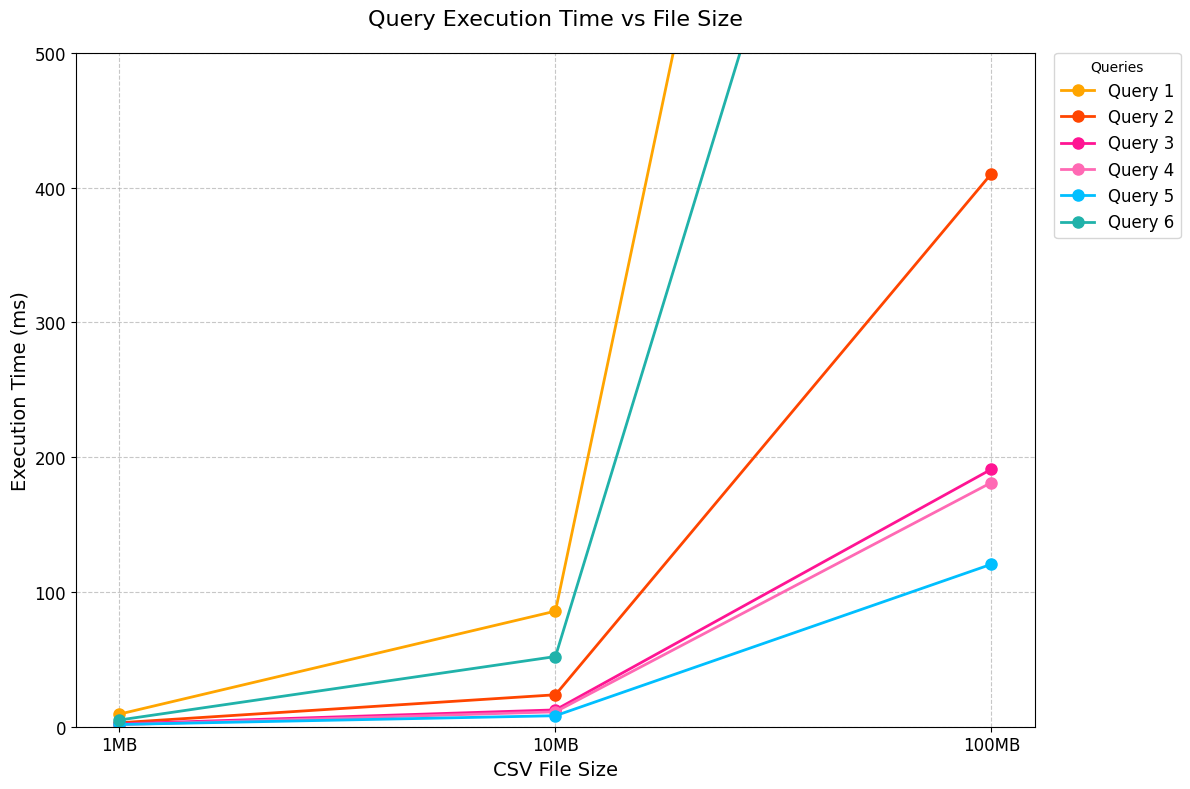

In [ ]:
import sqlite3
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

def load_csv_to_sqlite_normalized(csv_file_path):
    conn = sqlite3.connect(':memory:')
    df = pd.read_csv(csv_file_path)

    conn.execute("""
        CREATE TABLE IF NOT EXISTS Schools (
            SchoolID INTEGER PRIMARY KEY AUTOINCREMENT,
            SchoolName TEXT NOT NULL UNIQUE
        );
    """)
    conn.execute("""
        CREATE TABLE IF NOT EXISTS Departments (
            DepartmentID INTEGER PRIMARY KEY AUTOINCREMENT,
            DepartmentName TEXT NOT NULL UNIQUE
        );
    """)
    conn.execute("""
        CREATE TABLE IF NOT EXISTS Persons (
            PersonID INTEGER PRIMARY KEY AUTOINCREMENT,
            PersonName TEXT,
            BirthDate DATE,
            SchoolID INTEGER,
            JobTitle TEXT,
            Earnings FLOAT,
            StillWorking TEXT,
            DepartmentID INTEGER,
            FOREIGN KEY (SchoolID) REFERENCES Schools(SchoolID),
            FOREIGN KEY (DepartmentID) REFERENCES Departments(DepartmentID)
        );
    """)

    conn.executemany("INSERT OR IGNORE INTO Schools (SchoolName) VALUES (?);",
                     [(name,) for name in df['SchoolName'].dropna().unique()])
    conn.executemany("INSERT OR IGNORE INTO Departments (DepartmentName) VALUES (?);",
                     [(name,) for name in df['DepartmentName'].dropna().unique()])
    conn.executemany("""
        INSERT INTO Persons (PersonName, BirthDate, SchoolID, JobTitle, Earnings, StillWorking, DepartmentID)
        SELECT ?, ?, s.SchoolID, ?, ?, ?, d.DepartmentID
        FROM Schools s, Departments d
        WHERE s.SchoolName = ? AND d.DepartmentName = ?;
    """, [(row['PersonName'], row['BirthDate'], row['JobTitle'], row['Earnings'], row['StillWorking'], row['SchoolName'], row['DepartmentName']) for _, row in df.iterrows()])

    conn.commit()
    return conn

queries_content = """-- Query 1
SELECT PersonName
FROM Persons
WHERE SUBSTR(BirthDate, 7, 4) || '-' || SUBSTR(BirthDate, 1, 2) || '-' || SUBSTR(BirthDate, 4, 2) < '1975-01-01'
AND Earnings > 130000;

-- Query 2
SELECT DISTINCT PersonName, SchoolName
FROM Persons
JOIN Schools ON Persons.SchoolID = Schools.SchoolID
WHERE Earnings > 400000 AND StillWorking = 'no';

-- Query 3
SELECT PersonName
FROM Persons
JOIN Schools ON Persons.SchoolID = Schools.SchoolID
WHERE SchoolName = 'University of Texas'
AND JobTitle = 'Lecturer'
AND StillWorking = 'no';

-- Query 4
SELECT SchoolName, COUNT(PersonID) AS ActiveFacultyCount
FROM Persons
JOIN Schools ON Persons.SchoolID = Schools.SchoolID
WHERE StillWorking = 'yes'
GROUP BY SchoolName
ORDER BY ActiveFacultyCount DESC
LIMIT 1;

-- Query 5
SELECT PersonName, JobTitle, DepartmentName, SchoolName, Earnings
FROM Persons
JOIN Departments ON Persons.DepartmentID = Departments.DepartmentID
JOIN Schools ON Persons.SchoolID = Schools.SchoolID
WHERE PersonName = 'Ratnaraju Marpu';

-- Query 6
SELECT DepartmentName, AVG(Earnings) AS AverageEarnings
FROM Persons
JOIN Departments ON Persons.DepartmentID = Departments.DepartmentID
GROUP BY DepartmentName
ORDER BY AverageEarnings DESC
LIMIT 1;
"""

with open('queries.txt', 'w') as file:
    file.write(queries_content)

def execute_queries_from_file(conn, query_file):
    query_times = {}
    with open(query_file, 'r') as f:
        queries = f.read().split(';')[:-1]

    for i, query in enumerate(queries, 1):
        query_name = f"query{i}"
        start_time = time.time()
        result = conn.execute(query.strip()).fetchall()
        query_time = time.time() - start_time
        query_times[query_name] = query_time * 1000
        print(f"{query_name} executed in {query_time:.4f} seconds")
        print(result[:10])

    return query_times

def plot_query_performance(query_times_all, uploaded_files):
    plt.figure(figsize=(12, 8))

    colors = ['#FFA500', '#FF4500', '#FF1493', '#FF69B4', '#00BFFF', '#20B2AA']
    markers = 'o'

    file_sizes = ['1MB', '10MB', '100MB']
    x_positions = range(len(file_sizes))

    for i in range(6):
        query_times = [times[i] for times in query_times_all.values()]
        plt.plot(x_positions, query_times,
                label=f'Query {i+1}',
                color=colors[i],
                marker=markers,
                linewidth=2,
                markersize=8)

    plt.title('Query Execution Time vs File Size', fontsize=16, pad=20)
    plt.xlabel('CSV File Size', fontsize=14)
    plt.ylabel('Execution Time (ms)', fontsize=14)

    plt.xticks(x_positions, file_sizes, fontsize=12)
    plt.yticks(fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.legend(title='Queries', bbox_to_anchor=(1.02, 1),
               loc='upper left', borderaxespad=0, fontsize=12)

    plt.ylim(0, 500)

    plt.tight_layout()

    plt.show()

query_times_all = {}

uploaded = files.upload()

for uploaded_file in uploaded.keys():
    print(f"Processing file: {uploaded_file}")

    conn = load_csv_to_sqlite_normalized(uploaded_file)
    query_file = 'queries.txt'
    query_times = execute_queries_from_file(conn, query_file)

    query_times_all[uploaded_file] = []
    for i in range(1, 7):
        query_times_all[uploaded_file].append(query_times[f'query{i}'])

    conn.close()

plot_query_performance(query_times_all, uploaded)


File not found: /mnt/data/salary_tracker_1MB.csv
File not found: /mnt/data/salary_tracker_10MB.csv
File not found: /mnt/data/salary_tracker_100MB.csv

Loading 1MB data from /mnt/data/salary_tracker_1MB.csv...
Error processing /mnt/data/salary_tracker_1MB.csv: [Errno 2] No such file or directory: '/mnt/data/salary_tracker_1MB.csv'


OperationalError: no such column: s.SchoolName